N2550 - Fundementals of Image Processing and Machine Vision

Name : R.G.S.M. RANATUNGA

Index No. : 190504H

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

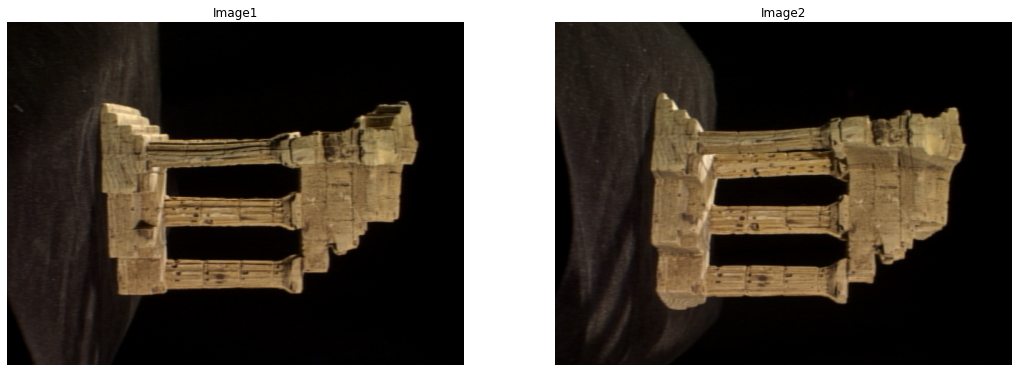

In [2]:
f = open(r'./templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())

# Reading the information on the first image
l = f.readline().split()
im1_fn = l[0]

K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading the information on the second image
l = f.readline().split()
im2_fn = l[0]

K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

#Read the two images and show
im1 = cv.imread(r'./templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'./templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)
assert im1 is not None 
assert im2 is not None 

fig,ax = plt.subplots(1,2,figsize = (18, 18))

ax[0].set_title('Image1')
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].set_title('Image2')
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].axis('off')

#Compute P1 and P2
P1 = K1 @ np.hstack((R1, t1)) #P =K*[R|t]
P2 = K2 @ np.hstack((R2, t2))


In [3]:
from scipy.linalg import null_space
def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

C = null_space(P1)
C = C* np.sign(C[0,0])
e2 = P2 @ C

e2x = skew(e2)

F = e2x @ P2 @np.linalg.pinv(P1)
F

array([[-2.87071497e-04, -3.96261289e-02,  2.94221686e+02],
       [-3.55039713e-02,  1.65329260e-04,  1.78860854e+01],
       [-2.76702814e+02,  2.12942175e+01, -9.06669374e+03]])

(-0.5, 639.5, 479.5, -0.5)

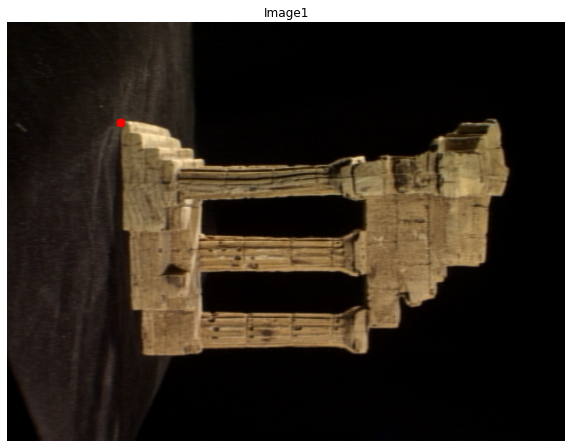

In [4]:
x = np.array([130, 115, 1])
cv.circle(im1, (x[0], x[1]), 5, (0, 0, 255), -1)

fig,ax = plt.subplots(figsize = (10, 10))
ax.set_title('Image1')
ax.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax.axis('off')

(-0.5, 639.5, 479.5, -0.5)

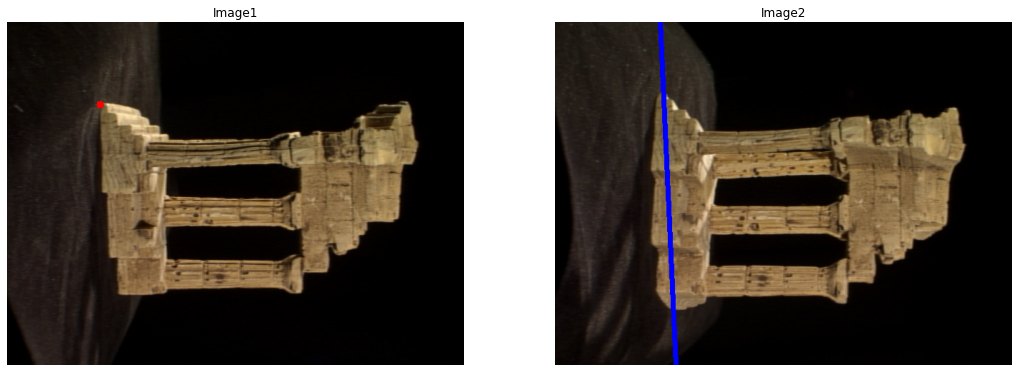

In [5]:
l2 = F @ x.T
p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500, (l2[0]*500 + l2[2])/l2[1]]).astype(int)

cv.line(im2, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 0), 5)

fig,ax = plt.subplots(1,2,figsize = (18, 18))
ax[0].set_title('Image1')
ax[0].imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB))
ax[0].axis('off')

ax[1].set_title('Image2')
ax[1].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[1].axis('off')